In [47]:
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as  dt
import pandas as pd
# import talib
import matplotlib.pyplot as plt
import datetime

In [48]:
# data = rel.history(period="1mo")
ticker_symbol = "RELIANCE.NS"

df = yf.download(ticker_symbol, period="1y")
df["Close"] = df["Adj Close"]
df = df.drop("Adj Close", axis = 1)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-06-20,2351.387939,2366.571045,2339.804199,2351.894531,3460548
2023-06-21,2360.110107,2371.970703,2351.803223,2358.516846,3480801
2023-06-22,2359.187256,2375.155029,2337.035156,2332.027832,3809583
2023-06-23,2334.173828,2338.327393,2318.575195,2312.943115,3314285
2023-06-26,2313.960205,2321.713379,2297.069336,2295.283936,6320579


## Indicators

In [49]:
def SMA(df, window=20):
  df['SMA'] = df['Close'].rolling(window=window).mean()
  return df

In [50]:
def Bollinger_bands(df, window=20, num_std=2):
  df = SMA(df, window)
  df['STD'] = df['Close'].rolling(window=20).std()

  df['Upper Band'] = df['SMA'] + (df['STD'] * num_std)
  df['Lower Band'] = df['SMA'] - (df['STD'] * num_std)

  return df

In [51]:
def Stochiastic_Oscillator(df, window = 14):
  df['Min'] = df['Low'].rolling(window=n).min()
  df['Max'] = df['High'].rolling(window=n).max()

  df['%K'] = 100 * ((df['Close'] - df['Min']) / (df['Max'] - df['Min'])) # fast stochiastic oscialltor
  df['%D'] = df['%K'].rolling(window=3).mean() # slow stochiastic oscillator

  return df

In [52]:
def EMA_12_26(df):
  df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
  df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()

  return df

def MACD(df):
  df = EMA_12_26(df)
  df['MACD'] = df['EMA_12'] - df['EMA_26']

  df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

  return df

In [53]:
def evening_star_candlestick(df):
  df['First'] = (df['Close'].shift(2) > df['Open'].shift(2)) & ((df['Close'].shift(2) - df['Open'].shift(2)) > (df['High'] - df['Low']).shift(2) * 0.6)
  df['Second'] = (df['Open'].shift(1) > df['Close'].shift(2)) & ((df['Close'].shift(1) < df['Open'].shift(1) * 1.01) & (df['Close'].shift(1) > df['Open'].shift(1) * 0.99))
  df['Third'] = (df['Open'] < df['Close'].shift(1)) & (df['Close'] < df['Open'].shift(2))

  df['Evening Star'] = df['First'] & df['Second'] & df['Third']

  return df

In [54]:
def RSI(df, window=14):
  delta = df['Close'].diff()

  gain = delta.where(delta > 0, 0)
  loss = -delta.where(delta < 0, 0)

  avg_gain = gain.rolling(window=window, min_periods=1).mean()
  avg_loss = loss.rolling(window=window, min_periods=1).mean()

  relative_strength = avg_gain / avg_loss

  # Calculate the RSI
  df['RSI'] = 100 - (100 / (1 + relative_strength))

  return df

## Graphs and plotting

### CandleStick Pattern

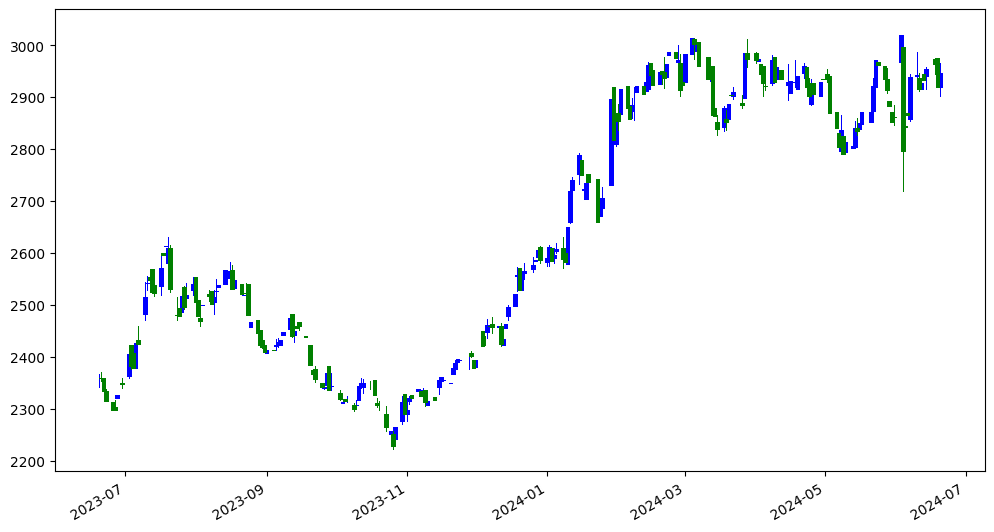

In [55]:
# Refernce Geeks for Geeks

stock_prices = df
stock_prices["close"] = stock_prices["Close"]
stock_prices["open"] = stock_prices["Open"]
stock_prices["high"] = stock_prices["High"]
stock_prices["low"] = stock_prices["Low"]

stock_prices = SMA(stock_prices)
stock_prices = Bollinger_bands(stock_prices)

plt.figure(figsize=(12, 6))

# "up" dataframe will store the stock_prices
# when the closing stock price is greater
# than or equal to the opening stock prices
up = stock_prices[stock_prices.close >= stock_prices.open]

# "down" dataframe will store the stock_prices
# when the closing stock price is
# lesser than the opening stock prices
down = stock_prices[stock_prices.close < stock_prices.open]

# When the stock prices have decreased, then it
# will be represented by blue color candlestick
col1 = 'blue'

# When the stock prices have increased, then it
# will be represented by green color candlestick
col2 = 'green'

# Setting width of candlestick elements
width = 2
width2 = .2

# Plotting up prices of the stock
plt.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
plt.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
plt.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)

# Plotting down prices of the stock
plt.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
plt.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
plt.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)

# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')

# displaying candlestick chart of stock data
# of a week
# plt.plot(stock_prices["Close"], color='red', alpha=0.5)

plt.show()


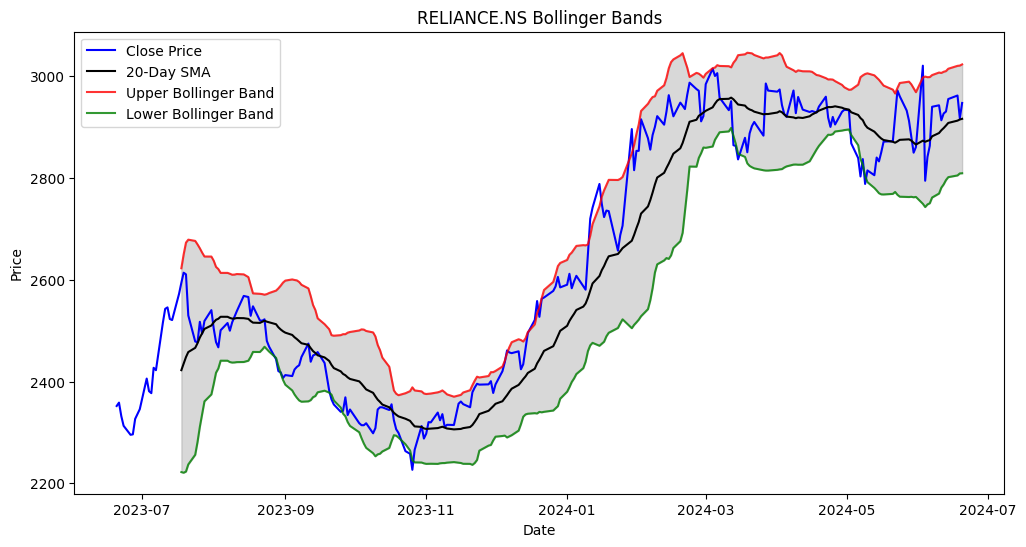

In [56]:
plt.figure(figsize=(12, 6))

plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.plot(df.index, df['SMA'], label='20-Day SMA', color='black')
plt.plot(df.index, df['Upper Band'], label='Upper Bollinger Band', color='red', alpha=0.8)
plt.plot(df.index, df['Lower Band'], label='Lower Bollinger Band', color='green', alpha=0.8)

plt.fill_between(df.index, df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3)
plt.title(f'{ticker_symbol} Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

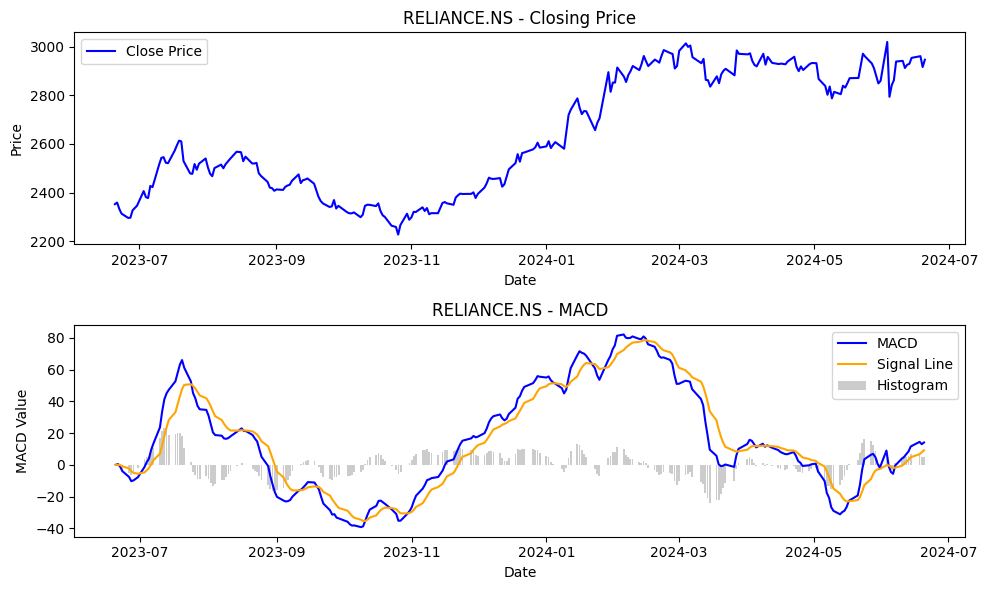

In [63]:
df = MACD(df)

plt.figure(figsize=(10, 6))

# Plot 1: Closing price
plt.subplot(2, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.title(f'{ticker_symbol} - Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot 2: MACD, Signal line, and Histogram
plt.subplot(2, 1, 2)
plt.plot(df.index, df['MACD'], label='MACD', color='blue')
plt.plot(df.index, df['MACD_Signal'], label='Signal Line', color='orange')
df['Histogram'] = df['MACD'] - df['MACD_Signal']
plt.bar(df.index, df['Histogram'], label='Histogram', color='grey', alpha=0.4)

plt.title(f'{ticker_symbol} - MACD')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()

plt.tight_layout()
plt.show()